<a href="https://colab.research.google.com/github/0xfffddd/Coding/blob/main/Figure_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

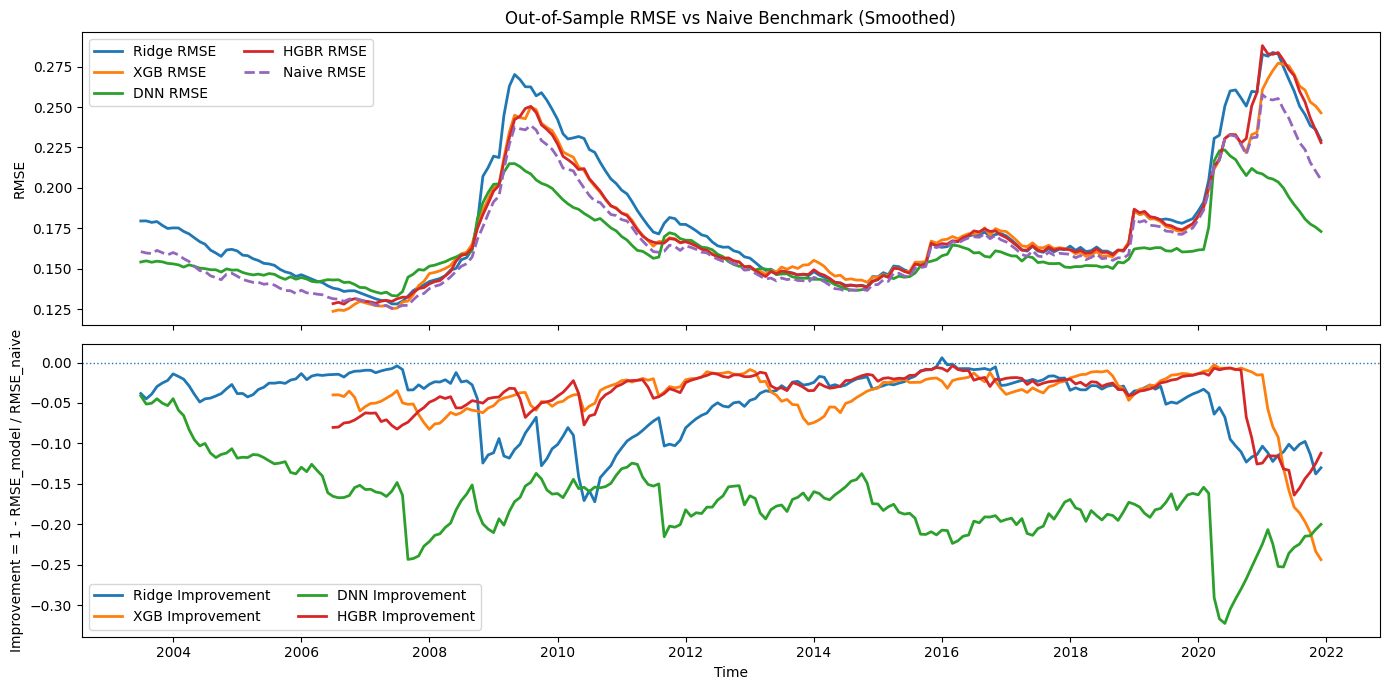

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========= load =========
ridge = pd.read_csv("metrics_Ridge.csv")
xgb   = pd.read_csv("metrics_XGB.csv")
dnn   = pd.read_csv("metrics_DNN.csv")
hgbr  = pd.read_csv("metrics_HGBR.csv")

for df in (ridge, xgb, dnn, hgbr):
    df["month"] = pd.to_datetime(df["month"])

def keep(df, tag):
    out = df[["month","model_rmse","naive_rmse","improvement"]].copy()
    out = out.rename(columns={
        "model_rmse": f"rmse_{tag}",
        "naive_rmse": f"naive_{tag}",
        "improvement": f"imp_{tag}"
    })
    return out

m = keep(ridge,"Ridge") \
    .merge(keep(xgb,"XGB"),   on="month", how="outer") \
    .merge(keep(dnn,"DNN"),   on="month", how="outer") \
    .merge(keep(hgbr,"HGBR"), on="month", how="outer") \
    .sort_values("month")


naive_cols = [c for c in m.columns if c.startswith("naive_")]
m["naive_rmse"] = m[naive_cols].median(axis=1)
m = m.drop(columns=naive_cols)


m = m.set_index("month").sort_index()
full_idx = pd.date_range(m.index.min(), m.index.max(), freq="MS")
m = m.reindex(full_idx)
m.index.name = "month"

models = ["Ridge","XGB","DNN","HGBR"]


def smooth(s, span=24):
    s2 = s.interpolate(method="time")
    return s2.ewm(span=24, adjust=False, min_periods=6).mean()


m["naive_sm"] = smooth(m["naive_rmse"])

for tag in models:
    m[f"rmse_sm_{tag}"] = smooth(m[f"rmse_{tag}"])
    m[f"imp_sm_{tag}"]  = smooth(m[f"imp_{tag}"])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,7), sharex=True)


for tag in models:
    ax1.plot(m.index, m[f"rmse_sm_{tag}"], linewidth=2, label=f"{tag} RMSE")

ax1.plot(m.index, m["naive_sm"], linestyle="--", linewidth=2, label="Naive RMSE")

ax1.set_ylabel("RMSE")
ax1.set_title("Out-of-Sample RMSE vs Naive Benchmark (Smoothed)")
ax1.legend(loc="upper left", ncol=2)


ax2.axhline(0, linestyle=":", linewidth=1)

for tag in models:
    ax2.plot(m.index, m[f"imp_sm_{tag}"], linewidth=2, label=f"{tag} Improvement")

ax2.set_ylabel("Improvement = 1 - RMSE_model / RMSE_naive")
ax2.set_xlabel("Time")
ax2.legend(loc="lower left", ncol=2)

plt.tight_layout()
plt.show()

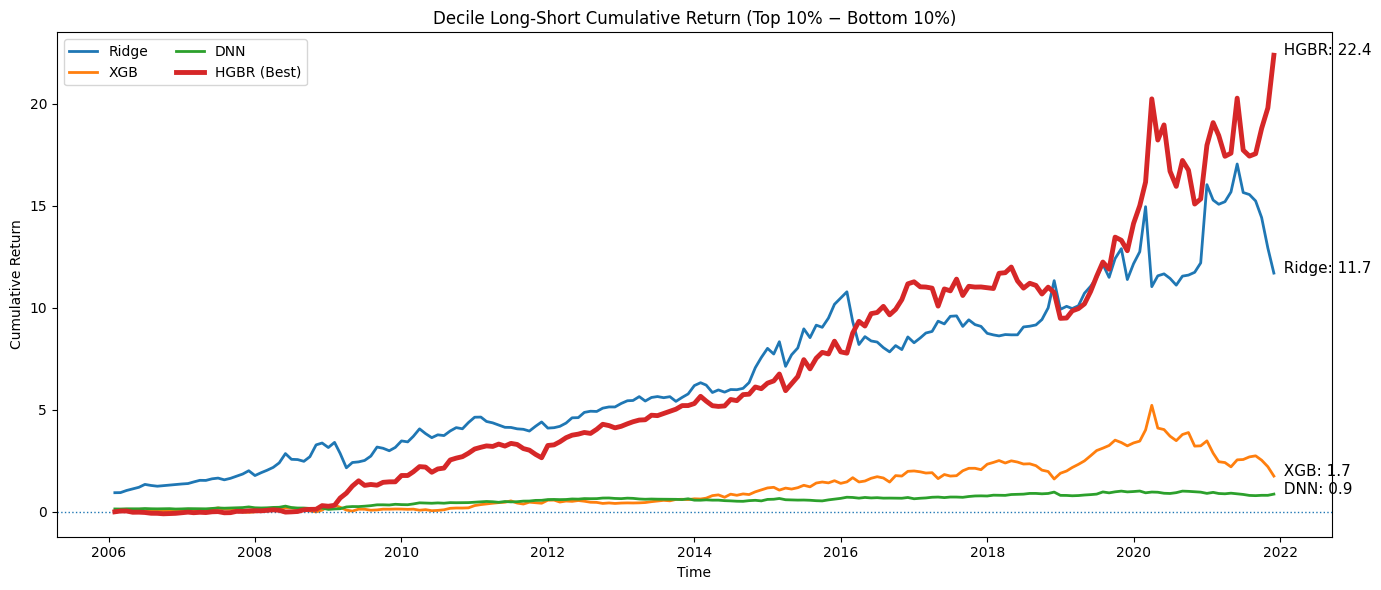

In [8]:
plt.figure(figsize=(14,6))

plt.plot(ridge_c["month"], ridge_c["cum_ls"], linewidth=2, label="Ridge")
plt.plot(xgb_c["month"],   xgb_c["cum_ls"],   linewidth=2, label="XGB")
plt.plot(dnn_c["month"],   dnn_c["cum_ls"],   linewidth=2, label="DNN")


plt.plot(hgbr_c["month"],  hgbr_c["cum_ls"],  linewidth=3.5, label="HGBR (Best)", zorder=5)

plt.axhline(0, linestyle=":", linewidth=1)

plt.title("Decile Long-Short Cumulative Return (Top 10% − Bottom 10%)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")

plt.legend(loc="upper left", ncol=2)


def annotate_last(df, name):
    x = df["month"].iloc[-1]
    y = df["cum_ls"].iloc[-1]
    plt.text(x, y, f"  {name}: {y:.1f}", fontsize=11)

annotate_last(hgbr_c,"HGBR")
annotate_last(ridge_c,"Ridge")
annotate_last(xgb_c,"XGB")
annotate_last(dnn_c,"DNN")

plt.tight_layout()
plt.show()